In [19]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [20]:
! gdown --id 1li63q87FFao8zyD0lRwxB-q5hnBIz-Vr

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1li63q87FFao8zyD0lRwxB-q5hnBIz-Vr
To: /kaggle/working/IMDB Dataset.csv
100%|███████████████████████████████████████| 66.2M/66.2M [00:00<00:00, 184MB/s]


In [21]:
pip install Keras-Preprocessing

Note: you may need to restart the kernel to use updated packages.


In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-07-17 15:02:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-17 15:02:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-17 15:02:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [28]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.tokenize import TreebankWordTokenizer
import re
from numpy import zeros
from keras.preprocessing.text import one_hot,Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation ,Dropout ,Dense
from keras.layers import Flatten,GlobalMaxPooling1D,Embedding,Conv1D,LSTM

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam,AdamW
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

In [30]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [31]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file='glove.6B.100d.txt'
glove_output_file='word.txt'

In [32]:
glove2word2vec(glove_input_file,glove_output_file)

/tmp/ipykernel_28/1793326920.py:1: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file,glove_output_file)


(400000, 100)

In [33]:
from gensim.models import KeyedVectors
GloVe=KeyedVectors.load_word2vec_format(glove_output_file,binary=False)

In [34]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
from sklearn.metrics import matthews_corrcoef
def matthews_correlation(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    y_pred_binary = tf.cast(y_pred_binary, tf.float32)
    mcc = matthews_corrcoef(y_true.numpy(), y_pred_binary.numpy())
    return mcc

In [36]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv",encoding_errors='ignore')

In [37]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [38]:
##first we need to perform basic eda on any dataset
print(df.shape)
##chceking for nan values
total_nan = df.isna().sum()
print(total_nan)

(50000, 2)
review       0
sentiment    0
dtype: int64


In [39]:
## we check for skewness of data as a positively or negatively skewed data can affect our model performance  drastically
positive_count,negative_count= 0, 0
for senti in df['sentiment']:
  if(senti=='positive'):
    positive_count+=1
  else:
    negative_count+=1;

In [40]:
count_list=[positive_count,negative_count]
list_sent=['positive','negative']
fig=plt.figure(figsize=(10,7))
fig=px.pie(values=count_list,names=list_sent,title='Distribution of Sentiment')
fig.show()
## we see that the data is not skewed, rather it is totally symmetrical

<Figure size 1000x700 with 0 Axes>

In [41]:
def clean_text(text):
  ##convert all text to lower case
  text=text.lower()
  ##remove html tags ,removes anything in <> with empty space
  text = re.sub('<[^<]+?>', '', text)
  ##covert instances of it's to it is to make better sense
  text=re.sub(r"it's","it is",text,flags=re.IGNORECASE)
  text=re.sub(r"i'm","i am",text,flags=re.IGNORECASE)
  ##remove special charecters and punctuation marks
  text = re.sub(r'[^a-zA-Z\s]', ' ', text)
  ##remove other instances of words like John's to John
  text=re.sub(r" 's\b ",'',text)
  ##removing multiple white spaces
  text=re.sub(r'\s+',' ',text)
  for word in stopwords.words('english'):
    text=re.sub('\s'+word+'\s',' ',text)
  return text;

In [42]:
text="Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not "
clean_text(text)

'probably time favorite movie story selflessness sacrifice dedication noble cause '

In [43]:
def sent_val(text):
  if(text=='positive'):
    return 1;
  else:
    return 0;

In [44]:
df['pre-processed review']=df['review'].apply(clean_text)

In [45]:
##convert sentiment into labels 0 and 1
df['sentiment value']=df['sentiment'].apply(sent_val)

In [46]:
def get_len(text):
  return len(text.split())

In [47]:
## we see that the average nuumber of words in the reviews is ~120
n,sum=df.shape[0],0
for text in df['pre-processed review']:
  sum+=get_len(text)
print(sum/n)

119.03436


In [48]:
x=df['pre-processed review'].tolist()
y=df['sentiment value'].tolist()

In [49]:
x=np.array(x)
y=np.array(y)

In [50]:
train_data,test_data,train_labels,test_labels=train_test_split(x,y,test_size=0.2,random_state=42)

Embedding Layer

In [51]:
## we need to create an embedding layer for which we will tokenize our reviews using TreeBankTokenizer from nltk or word_tokenize
word_tokenizer=Tokenizer()
word_tokenizer.fit_on_texts(train_data)

In [52]:
# #word_tokenizer=Tokenizer()
# tokenized_reviews=[]
# tokenized_reviews=word_tokenizer.texts_to_sequences(x)

In [53]:
# ## we need to generate masks for input in transformer model later
# masks= list()
# for tokens in tokenized_reviews:
#   mask=[]
#   for token in tokens:
#     if(token>0):
#       mask.append(1)
#     else:
#       mask.append(0)
#   masks.append(mask)

In [54]:
# train_masks,test_masks=train_test_split(masks,test_size=0.2,random_state=42)

In [55]:
##tokenize train test and validation data
X_train=word_tokenizer.texts_to_sequences(train_data)
X_test=word_tokenizer.texts_to_sequences(test_data)
##tokenization complete

In [56]:
##number of unique words in our entire review dataset
len(word_tokenizer.word_index)
word_tokenizer.word_index['used']
words=word_tokenizer.word_index.keys()
word_list=[]
for word in words:
  word_list.append(word)

In [57]:
word_list[0]
GloVe[word_list[0]]
word_tokenizer.word_index[word_list[0]]

1

In [58]:
## we truncate or zero pad all reviews till 120 words as it is the average length of reviews
length=100
X_train=pad_sequences(X_train,padding='post',maxlen=length)
X_test=pad_sequences(X_test,padding='post',maxlen=length)

In [59]:
## we create an embedding matrix
embedding_matrix=zeros((len(word_list)+1,length))
count=0
for word in word_list:
  if word in GloVe.key_to_index:
    vector=GloVe[word]
  index=word_tokenizer.word_index[word]
  if vector is not None:
    embedding_matrix[index]=vector
embedding_matrix.shape
##each column of embedding matrix depicts the vector of word corresponding to its index number

(92525, 100)

Simple Neural Network

In [60]:

model=Sequential()
word_embedding_layer=Embedding(len(word_list)+1,100,weights=[embedding_matrix],input_length=100,trainable=False)
## add the embedding layer to the model
model.add(word_embedding_layer)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))


In [61]:
## model compile
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9252500   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9,262,501
Trainable params: 10,001
Non-trainable params: 9,252,500
_________________________________________________________________
None


In [62]:
## trainig model
model_history=model.fit(X_train,train_labels,batch_size=64,epochs=8,verbose=1,validation_split=0.2)

Epoch 1/8
500/500 [==============================] - 7s 3ms/step - loss: 0.6397 - acc: 0.6301 - val_loss: 0.5924 - val_acc: 0.6891
Epoch 2/8
500/500 [==============================] - 2s 3ms/step - loss: 0.5534 - acc: 0.7266 - val_loss: 0.5531 - val_acc: 0.7262
Epoch 3/8
500/500 [==============================] - 2s 3ms/step - loss: 0.5134 - acc: 0.7597 - val_loss: 0.5313 - val_acc: 0.7427
Epoch 4/8
500/500 [==============================] - 1s 3ms/step - loss: 0.4874 - acc: 0.7776 - val_loss: 0.5178 - val_acc: 0.7536
Epoch 5/8
500/500 [==============================] - 1s 3ms/step - loss: 0.4683 - acc: 0.7897 - val_loss: 0.5097 - val_acc: 0.7565
Epoch 6/8
500/500 [==============================] - 1s 3ms/step - loss: 0.4531 - acc: 0.8012 - val_loss: 0.5027 - val_acc: 0.7621
Epoch 7/8
500/500 [==============================] - 2s 3ms/step - loss: 0.4407 - acc: 0.8086 - val_loss: 0.5019 - val_acc: 0.7628
Epoch 8/8
500/500 [==============================] - 2s 3ms/step - loss: 0.4304 - a

In [63]:
score=model.evaluate(X_test,test_labels,verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5065 - acc: 0.7601


In [64]:
print("Test score",score[0])
print("Test accuracy",score[1])

Test score 0.5064690709114075
Test accuracy 0.7601000070571899


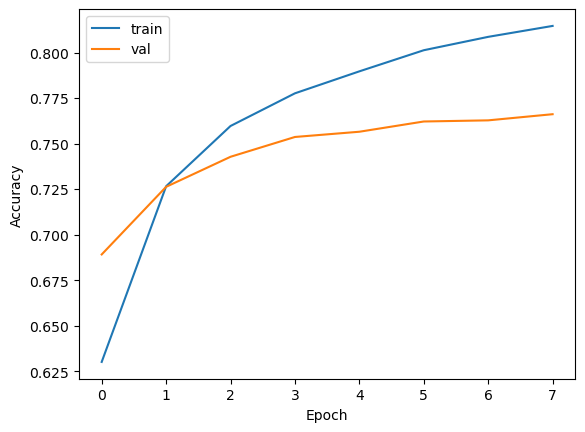

In [65]:
## we plot model train and test accuracy on validation set with each epoch
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

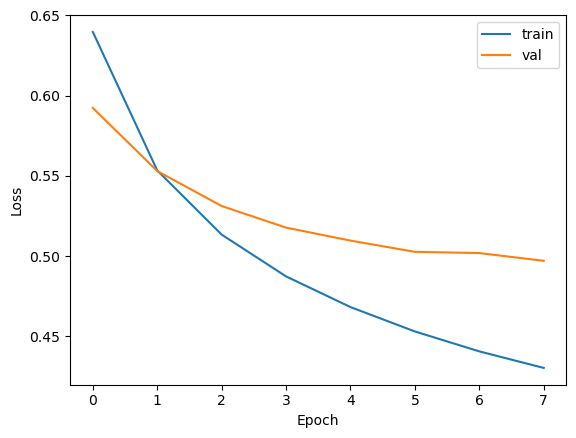

In [66]:
## we plot model train and test loss on validation set with each epoch
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [67]:
def get_prediction(review):
  review=clean_text(review)
  X_review=word_tokenizer.texts_to_sequences([review])
  X_review=np.array(X_review)
  X_review=pad_sequences(X_review,padding='post',maxlen=length)
  score=model.predict(X_review)
  print(score)
  if(score>0.7):
      return "positive"
  else:
    return "negative"

In [68]:
## lets test our model on some input  reviews(reviews should be approx 100 words to be accurate)
review="Parasite is a masterclass in storytelling and social commentary. Bong Joon-ho's direction is flawless, seamlessly blending genres while keeping the audience on edge. The performances are exceptional, and the film's exploration of class divides is both thought-provoking and impactful. A truly brilliant and unforgettable cinematic experience."
get_prediction(review)

1/1 [==============================] - 0s 82ms/step
[[0.8455499]]


'positive'

In [69]:
y_pred=model.predict(X_test)

313/313 [==============================] - 0s 1ms/step


In [70]:
pred_arr=[]
for pred in y_pred:
  if (pred>0.7):
    pred=1
  else:
    pred=0
  pred_arr.append(pred)
##print(pred_arr)
pred_arr=np.array(pred_arr)
print(matthews_correlation(pred_arr,test_labels))

0.4595151448764435


In [71]:
from sklearn.metrics import f1_score
f1=f1_score(pred_arr,test_labels)
print(f1)

0.6305443548387096


Convolutional Neural Net

In [72]:
## we now design a convolutional neural network
cnn_model=Sequential()
## add an embedding layer
word_embedding_layer_cnn=Embedding(len(word_list)+1,100,weights=[embedding_matrix],input_length=100,trainable=False)
cnn_model.add(word_embedding_layer)
cnn_model.add(Conv1D(filters=256,kernel_size=5,activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=1,activation='sigmoid'))

In [73]:
## compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9252500   
                                                                 
 conv1d (Conv1D)             (None, 96, 256)           128256    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9,381,013
Trainable params: 128,513
Non-trainable params: 9,252,500
_________________________________________________________________
None


In [74]:
tf.test.is_gpu_available()

True

In [75]:
## model training
cnn_history=cnn_model.fit(X_train,train_labels,batch_size=64,epochs=10,verbose=2,validation_split=0.2)

Epoch 1/10
500/500 - 8s - loss: 0.5872 - acc: 0.7059 - val_loss: 0.5146 - val_acc: 0.7696 - 8s/epoch - 15ms/step
Epoch 2/10
500/500 - 2s - loss: 0.4613 - acc: 0.7988 - val_loss: 0.4375 - val_acc: 0.8119 - 2s/epoch - 3ms/step
Epoch 3/10
500/500 - 2s - loss: 0.3988 - acc: 0.8312 - val_loss: 0.4011 - val_acc: 0.8261 - 2s/epoch - 3ms/step
Epoch 4/10
500/500 - 2s - loss: 0.3626 - acc: 0.8485 - val_loss: 0.3774 - val_acc: 0.8370 - 2s/epoch - 3ms/step
Epoch 5/10
500/500 - 2s - loss: 0.3368 - acc: 0.8613 - val_loss: 0.3651 - val_acc: 0.8421 - 2s/epoch - 3ms/step
Epoch 6/10
500/500 - 2s - loss: 0.3158 - acc: 0.8736 - val_loss: 0.3571 - val_acc: 0.8444 - 2s/epoch - 3ms/step
Epoch 7/10
500/500 - 2s - loss: 0.2971 - acc: 0.8846 - val_loss: 0.3496 - val_acc: 0.8487 - 2s/epoch - 3ms/step
Epoch 8/10
500/500 - 2s - loss: 0.2813 - acc: 0.8922 - val_loss: 0.3439 - val_acc: 0.8490 - 2s/epoch - 3ms/step
Epoch 9/10
500/500 - 2s - loss: 0.2661 - acc: 0.9010 - val_loss: 0.3461 - val_acc: 0.8476 - 2s/epoch - 

In [76]:
score=cnn_model.evaluate(X_test,test_labels,verbose=2)

313/313 - 1s - loss: 0.3479 - acc: 0.8468 - 919ms/epoch - 3ms/step


In [77]:
print("Test score",score[0])
print("Test accuracy",score[1])

Test score 0.3479432463645935
Test accuracy 0.8468000292778015


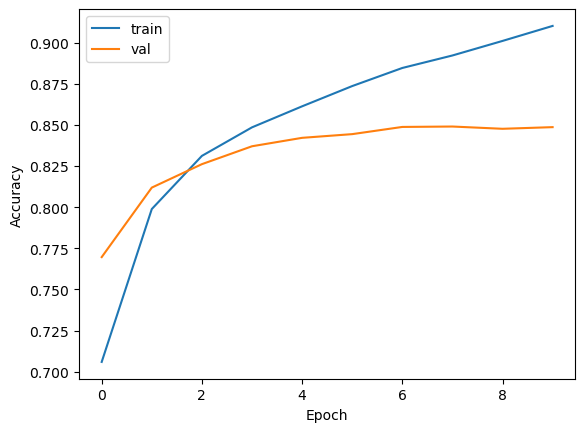

In [78]:
## we plot model train and test accuracy on validation set with each epoch
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

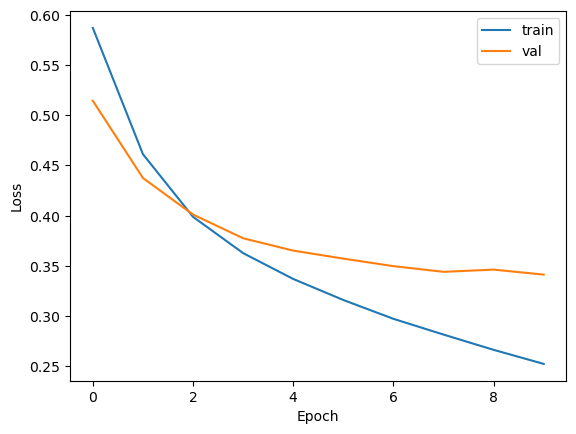

In [79]:
## we plot model train and test loss on validation set with each epoch
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [80]:
def get_prediction_cnn(review):
  review=clean_text(review)
  X_review=word_tokenizer.texts_to_sequences([review])
  X_review=np.array(X_review)
  X_review=pad_sequences(X_review,padding='post',maxlen=length)
  score=cnn_model.predict(X_review)
  print(score)
  if(score>0.7):
      return "positive"
  else:
    return "negative"

In [81]:
## lets test our model on some input  reviews(reviews should be approx 100 words to be accurate)
review="How I Met Your Mother entertained audiences with its mix of humor and heartfelt moments. The sitcom's witty writing and ensemble cast created engaging dynamics and memorable characters. While the storytelling occasionally meandered, it offered a sense of nostalgic charm and relatability. The show's focus on friendships and the ups and downs of adult life struck a chord with viewers. Although the finale faced divided opinions, the overall journey was filled with laughs and touching moments.How I Met Your Mother holds a place in television history as a beloved sitcom that provided enjoyable escapades and resonated with fans seeking both comedy and genuine connections."
get_prediction_cnn(review)

1/1 [==============================] - 0s 130ms/step
[[0.9940361]]


'positive'

In [82]:
y_pred=cnn_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [83]:
pred_arr=[]
for pred in y_pred:
  if (pred>0.6):
    pred=1
  else:
    pred=0
  pred_arr.append(pred)
##print(pred_arr)
pred_arr=np.array(pred_arr)
print(matthews_correlation(pred_arr,test_labels))

0.6754532082852347


In [84]:
from sklearn.metrics import f1_score
f1=f1_score(pred_arr,test_labels)
print(f1)

0.8191259195153613


In [85]:
## we see that the cnn model performs better than the simple neural net model because it has a lot greater number of trainable parameters which
## help in capturing the model complexity to a great extent.

LSTM Model

In [86]:
## Long Short Term Memory Model are very similar to Gated Reccurent Neural Networks
## we now design a convolutional neural network
lstm_model=Sequential()
## add an embedding layer
word_embedding_layer_cnn=Embedding(len(word_list)+1,100,weights=[embedding_matrix],input_length=100,trainable=False)
lstm_model.add(word_embedding_layer)
lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(100,100 )))
lstm_model.add(Flatten())
lstm_model.add(Dense(units=1,activation='sigmoid'))

In [87]:
optimizer = AdamW(weight_decay=0.01)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3)

In [88]:
lstm_model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9252500   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 9,349,781
Trainable params: 97,281
Non-trainable params: 9,252,500
_________________________________________________________________
None


In [89]:
lstm_history=lstm_model.fit(X_train,train_labels,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 18s 13ms/step - loss: 0.4431 - acc: 0.7942 - val_loss: 0.3649 - val_acc: 0.8432
Epoch 2/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3436 - acc: 0.8523 - val_loss: 0.3591 - val_acc: 0.8396
Epoch 3/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2865 - acc: 0.8815 - val_loss: 0.3469 - val_acc: 0.8559
Epoch 4/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.2312 - acc: 0.9052 - val_loss: 0.3657 - val_acc: 0.8485
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1643 - acc: 0.9362 - val_loss: 0.4832 - val_acc: 0.8305
Epoch 6/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1110 - acc: 0.9604 - val_loss: 0.4920 - val_acc: 0.8394
Epoch 7/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0720 - acc: 0.9773 - val_loss: 0.5149 - val_acc: 0.8393
Epoch 8/10
1000/1000 [==========================

In [90]:
score=lstm_model.evaluate(X_test,test_labels,verbose=2)

313/313 - 2s - loss: 0.6807 - acc: 0.8334 - 2s/epoch - 8ms/step


In [91]:
print("Test score",score[0])
print("Test accuracy",score[1])

Test score 0.680651068687439
Test accuracy 0.8334000110626221


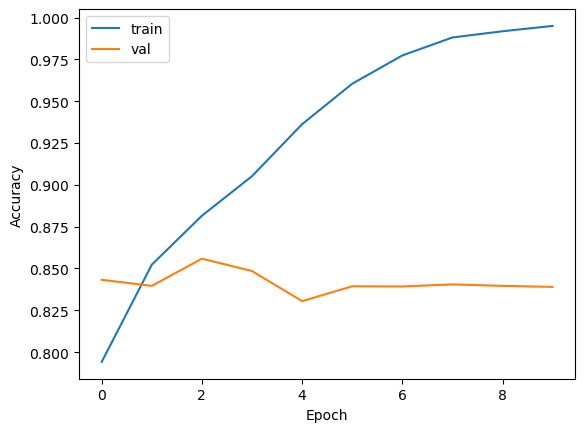

In [92]:
## we plot model train and test accuracy on validation set with each epoch
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

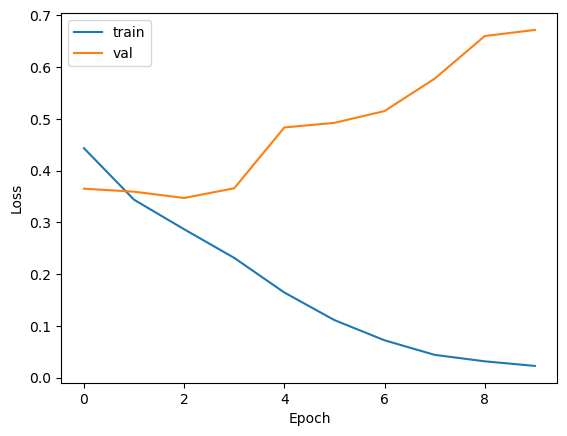

In [93]:
## we plot model train and test loss on validation set with each epoch
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

In [94]:
def get_prediction_lstm(review):
  review=clean_text(review)
  X_review=word_tokenizer.texts_to_sequences([review])
  X_review=np.array(X_review)
  X_review=pad_sequences(X_review,padding='post',maxlen=length)
  score=lstm_model.predict(X_review)
  print(score)
  if(score>0.6):
      return "positive"
  else:
    return "negative"

In [95]:
review="While the movie had its flaws, it managed to showcase some redeeming qualities. The performances, though not exceptional, had moments of sincerity that resonated with the audience. The cinematography, while inconsistent, occasionally presented visually striking scenes. The story, although lacking depth, had a few intriguing plot points that sparked interest. The soundtrack was a standout, enhancing certain key moments. However, these positive aspects were overshadowed by the film's overall shortcomings. The underdeveloped characters, predictable narrative, and missed opportunities for genuine emotional impact ultimately hindered the movie from reaching its full potential, resulting in a disappointing experience."
get_prediction_lstm(review)

1/1 [==============================] - 1s 676ms/step
[[0.00020164]]


'negative'

In [96]:
y_pred=lstm_model.predict(X_test)

313/313 [==============================] - 2s 5ms/step


In [97]:
pred_arr=[]
for pred in y_pred:
  if (pred>0.6):
    pred=1
  else:
    pred=0
  pred_arr.append(pred)
##print(pred_arr)
pred_arr=np.array(pred_arr)
print(matthews_correlation(pred_arr,test_labels))

0.6611967886528156


In [98]:
from sklearn.metrics import f1_score
f1=f1_score(pred_arr,test_labels)
print(f1)

0.8282562493674729


Sentiment Analysis using BERT

In [99]:
import torch
import tensorflow as tf

In [100]:
device = tf.test.gpu_device_name()
if device == '/device:GPU:0':
  print('GPU Found at: {}'.format(device))
else:
  raise SystemError('GPU Device Not Found')

GPU Found at: /device:GPU:0


In [101]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

We will use the GPU: Tesla T4


In [102]:
!pip install transformers

In [103]:
x=df['pre-processed review'].tolist()
y=df['sentiment value'].tolist()

In [104]:
x=np.array(x)
y=np.array(y)

In [105]:
print(len(x[26745].split()))

141


In [106]:
## find max_length of reviews
max_length=0
avg_length=0
for sentence in x:
    length=len(sentence.split())
    avg_length+=length
    if(length>max_length):
        max_length=length
avg_length=avg_length/len(x)

In [107]:
max_length=max_length+5

In [108]:
print(avg_length)
avg_length=120

119.03436


In [109]:
print(max_length)

1422


In [110]:
from transformers import BertTokenizer
wrd_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_sentences=[]
for sentence in x:
    sentence = wrd_tokenizer.encode(sentence)
    tokenized_sentences.append(sentence)

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


In [111]:
## pad the tokenized sentences
tokenized_sentences=pad_sequences(tokenized_sentences,maxlen=avg_length,value=0,padding='post')

In [112]:
print(tokenized_sentences)

[[ 3827  4442  3221 ...  9904  2217   102]
 [  101  1037  6919 ...     0     0     0]
 [  101  1045  2245 ...     0     0     0]
 ...
 [ 4732  2816 16752 ... 13725  7988   102]
 [ 2094  6476  4998 ...  5082  3288   102]
 [  101  2053  2028 ...     0     0     0]]


In [113]:
masks=[]
for tokenized_sentence in tokenized_sentences:
    mask = [int(token > 0) for token in tokenized_sentence]
    masks.append(mask)

In [114]:
X_train,X_test,train_labels,test_labels=train_test_split(tokenized_sentences,y,test_size=0.2,random_state=42)
X_train,X_val,train_labels,val_labels=train_test_split(X_train,train_labels,test_size=0.2,random_state=42)
train_masks,test_masks=train_test_split(masks,test_size=0.2,random_state=42)
train_masks,val_masks=train_test_split(train_masks,test_size=0.2,random_state=42)

In [115]:
## convert arrays to tensors for input into torch
X_train=torch.tensor(X_train)
train_labels=torch.tensor(train_labels)
train_masks=torch.tensor(train_masks)

X_test=torch.tensor(X_test)
test_labels=torch.tensor(test_labels)
test_masks=torch.tensor(test_masks)

X_val=torch.tensor(X_val)
val_labels=torch.tensor(val_labels)
val_masks=torch.tensor(val_masks)



In [116]:
from torch.utils.data import TensorDataset,RandomSampler,DataLoader,SequentialSampler

In [117]:

train_data=TensorDataset(X_train,train_masks,train_labels)
sampler_train=RandomSampler(train_data)
loader_train=DataLoader(train_data,sampler=sampler_train,batch_size=32)
val_data=TensorDataset(X_val,val_masks,val_labels)
sampler_val=RandomSampler(val_data)
loader_val=DataLoader(val_data,sampler=sampler_val,batch_size=32)

In [119]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [120]:
optimizer  = AdamW(model.parameters(),lr = 3e-5,eps = 1e-8,)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [121]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = epochs*len(loader_train)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [122]:
## defining flat accuracy
def flat_accuracy(pred_label,actual_label):
    pred_label_flat=np.argmax(pred_label,axis=1).flatten()
    actual_label_flat=actual_label.flatten()
    acc=np.sum(actual_label_flat==pred_label_flat)/len(actual_label_flat)
    return acc

In [123]:
a=10
print(str(a)+"hi")

10hi


In [124]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

losses=[]

for epoch_no in range (0,epochs):
    loss=0
    net_loss=0
    model.train()
    print("/n")
    print("training"+str(epoch_no+1)+"/"+str(epochs))
    for step,batch in enumerate(loader_train):
        batch = tuple(t.to(device) for t in batch)
        t_ids,t_mask,t_labels = batch
        
        model.zero_grad()
        output=model(t_ids,token_type_ids=None,attention_mask=t_mask,labels=t_labels)
        loss=output[0]
        net_loss+=loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()
        scheduler.step()
    avg_loss=net_loss/len(loader_train)
    print("Average Training Loss "+str(avg_loss))
    losses.append(avg_loss)
    
    print("Validation")
    model.eval()
    eval_acc_temp=0
    eval_acc=0
    eval_steps=0
    
    for batch in loader_val:
        batch=tuple(t.to(device) for t in batch)
        t_ids,t_mask,t_labels = batch
        with torch.no_grad():
            output=model(t_ids,token_type_ids=None,attention_mask=t_mask)
        logits=output[0]
        logits=logits.detach().cpu().numpy()
        labels = t_labels.to('cpu').numpy()
        eval_acc_temp=flat_accuracy(logits,labels)
        eval_acc+=eval_acc_temp
        eval_steps+=1
        acc=eval_acc/eval_steps
    print("validation accuracy is "+str(acc))

/n
training1/4
Average Training Loss 0.3154728525429964
Validation
validation accuracy is 0.905125
/n
training2/4
Average Training Loss 0.17665367871616036
Validation
validation accuracy is 0.904
/n
training3/4
Average Training Loss 0.09319013771065511
Validation
validation accuracy is 0.9045
/n
training4/4
Average Training Loss 0.04795167934824712
Validation
validation accuracy is 0.90275


In [125]:
test_data = TensorDataset(X_test,test_masks,test_labels)
sampler_test = RandomSampler(test_data)
loader_test = DataLoader(test_data,sampler=sampler_test,batch_size=32)

In [126]:
## predicting the test labels
model.eval()
pred_label,true_label=list(),list()
for batch in loader_test:
    batch=tuple(t.to(device) for t in batch)
    t_ids,t_mask,t_labels = batch
    with torch.no_grad():
        output=model(t_ids,token_type_ids=None,attention_mask=t_mask)
    logits=output[0]
    logits=logits.detach().cpu().numpy()
    labels=t_labels.to('cpu').numpy()
    pred_label.append(logits)
    true_label.append(labels)
print("predictions complete")

predictions complete


Testing the model

In [127]:
pred_label_new=[]
for label in pred_label:
    label_max=np.argmax(label,axis=1).flatten()
    pred_label_new.append(label_max)

In [128]:
print(pred_label)

[array([[ 3.5209038, -3.592734 ],
       [-1.2636334,  1.5944691],
       [ 3.0255728, -3.4057488],
       [-2.956024 ,  3.7631986],
       [ 2.719471 , -3.184375 ],
       [ 1.5231824, -2.1042545],
       [ 3.0139086, -3.4703925],
       [-1.7680708,  2.3156292],
       [-1.8400874,  2.5272691],
       [-2.947396 ,  3.6910536],
       [ 3.4857259, -3.6946256],
       [ 3.1978762, -3.5468023],
       [-2.9040413,  3.7265487],
       [-2.9227884,  3.6471057],
       [ 3.4413738, -3.6523333],
       [-2.637897 ,  3.5221426],
       [ 3.514091 , -3.631798 ],
       [-2.7860696,  3.5859008],
       [-2.516605 ,  3.4692965],
       [-2.943772 ,  3.7447615],
       [-2.8246439,  3.6623247],
       [ 3.106155 , -3.4586937],
       [ 2.261281 , -2.6987596],
       [-2.8815103,  3.7170975],
       [-2.8305874,  3.6742418],
       [ 0.9172744, -1.074538 ],
       [-3.0334213,  3.6967504],
       [ 3.357536 , -3.6528656],
       [ 3.467632 , -3.6111288],
       [-2.648277 ,  3.47832  ],
       [-

In [133]:
print(true_label[0])

[0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0]


In [134]:
labels_true=[]
for labels in true_label:
    for label in labels:
        labels_true.append(label)

In [136]:
print(pred_label_new[0])

[0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0]


In [137]:
labels_pred=[]
for labels in pred_label_new:
    for label in labels:
        labels_pred.append(label)

Matthews Correlation

In [138]:
print(matthews_correlation(labels_pred,labels_true))
## a noticable increase in mcc score from previous models

0.8140146404124788


F1 score

In [140]:
f1=f1_score(labels_pred,labels_true)
print(f1)
## large increase in f1 score as compared to previos models

0.9074258411307983
